In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function (lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### Before submitting, make sure you are adhering to the following rules, which helps us grade your assignment.  Assignments that do not adhere to these rules will be penalized.

 * Make sure your notebook only contains the exercises requested in the notebook, and the written homework (if any) is delivered in class in printed form, i.e. don't submit your written homework as part of the notebook.
 * Make sure you are using Python3.  This notebook is already set up to use Python3 (top right corner);  Do not change this.
 * If a method is provided with a specific signature, do not change the signature in any way, or the default values.
 * Don't hard-code your solutions to the specific environments which it is being used on, or the specific hyper-parameters which it is being used on;  Be as general as possible, which means also using ALL the arguments of the methods your are implementing.
 * Clean up your code before submitting, i.e. remove all print statements that you've used to develop and debug (especially if it's going to clog up the interface by printing thousands of lines).  Only output whatever is required by the exercise.
 * For technical reasons, plots should be contained in their own cell which should run instantly, separate from cells which perform longer computations.  This notebook is already formatted in such a way, please make sure this remains the case.
 * Make sure your notebook runs completely, from start to end, without raising any unintended errors.  After you've made the last edit, Use the option `Kernel -> Restart & Run All` to rerun the entire notebook.  If you end up making ANY edit, re-run everything again.  Always assume any edit you make may have broken your code!

# Homework 6: Deep Q-Networks in Pytorch

In this assignment you will implement deep q-learning using Pytorch.

In [2]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import cv2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 4]

cuda


#### Environments

In this notebook, we will implement DQN and run it on four environments which have a continuous state-space and discrete action-space.  There are:

 * CartPole:  Balance a pole on a moving cart (https://gym.openai.com/envs/CartPole-v1/).

In [3]:
envs = {
    "cartpole": gym.make("CartPole-v1", render_mode="rgb_array"),
}

These environments are particularly cool because they all include a graphical visualization which we can use to visualize our learned policies.  Run the folling cell and click the buttons to run the visualization with a random policy.

In [4]:
def preprocess_frame(img, size=(400, 100)):
    # cut off parts of image that nothing is happening in    
    img = img[150:300]
    

    # take just the G values
    img = img[:, :, 1]

    # make black and white
    img = np.where(img == 255, 1.0, 0.0)

    # resize
    img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)


    return img

In [5]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    env.render()

    while True:
        action = policy(state)
        state, _, done, _, _ = env.step(action)
        env.render()

        if done:
            break

    env.close()

In [6]:
#  Jupyter UI
def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False


buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print("Click a button to run a random policy:")
widgets.HBox(buttons)

Click a button to run a random policy:


## Misc Utilities

Some are provided, some you should implement

### Smoothing

In this homework, we'll do some plotting of noisy data, so here is the smoothing function which was also used in the previous homework.

In [7]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

In [8]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = np.log(self.value_to / self.value_from) / (self.num_steps - 1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        value = self.value_from

        if step > 0 and step < self.num_steps - 1:
            value = self.a * np.exp(self.b * step)

        elif step >= self.num_steps - 1:
            value = self.value_to

        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f"For step {step}, the scheduler returned {v} instead of {value}"
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

In [9]:
BUFFER_SIZE = 4
IMAGE_SHAPE = (100, 400)
OBSERVATION_SHAPE = (BUFFER_SIZE, *IMAGE_SHAPE)

class ImageBuffer:
    def __init__(self, num_images=BUFFER_SIZE, image_shape=IMAGE_SHAPE):
        """Buffer for storing images.

        :param num_images:  Number of images to store.
        """
        self.num_images = num_images
        self.image_shape = image_shape
        self.images = np.zeros((num_images, *image_shape), dtype=np.float32)

    def add(self, image):
        """Add an image to the buffer.

        :param image:  Image to add.
        """
        self.images = np.roll(self.images, -1, axis=0)
        self.images[-1] = image

    def get(self):
        """Get all images in the buffer.

        :return:  All images in the buffer.
        """
        return self.images
    
    def reset(self):
        self.images = np.zeros((self.num_images, *self.image_shape), dtype=np.float32)

In [10]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple("Batch", ("states", "actions", "rewards", "next_states", "dones"))


class ReplayMemory:
    def __init__(self, max_size, state_shape):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_shape

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, *state_shape))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, *state_shape))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0
        
        self.img_buff = ImageBuffer(BUFFER_SIZE, IMAGE_SHAPE)

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        self.states[self.idx] = torch.from_numpy(state)
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = torch.from_numpy(next_state)
        self.dones[self.idx] = done

        # DO NOT EDIT
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # YOUR CODE HERE:  randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.

        num_to_sample = min(batch_size, self.size)

        sample_indices = np.random.randint(0, self.size, num_to_sample)

        batch_states = self.states[sample_indices]
        batch_actions = self.actions[sample_indices]
        batch_rewards = self.rewards[sample_indices]
        batch_next_states = self.next_states[sample_indices]
        batch_dones = self.dones[sample_indices]

        batch = Batch(
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
        )

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # YOUR CODE HERE:  run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint:  don't repeat code!  Use the self.add() method!
        steps = 0
        
        
        pbar = tqdm.notebook.trange(num_steps)

        state, _ = env.reset()
        self.img_buff.reset()
        done = False
        self.img_buff.add(preprocess_frame(env.render()))

        while steps < num_steps:
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            pbar.update(1)

            state = self.img_buff.get()
            
            self.img_buff.add(preprocess_frame(env.render()))
            next_state = self.img_buff.get()


            self.add(state, action, reward, next_state, done)
            
            steps += 1

            if done:
                state, _ = env.reset()
                done = False
                self.img_buff.reset()

In [11]:
class DQN(nn.Module):
    def __init__(self, state_dim=OBSERVATION_SHAPE, action_dim=2, dense_dim=128):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.dense_dim = dense_dim

        self.layers = nn.ModuleList()

        self.layers.append(
            nn.Conv2d(
                OBSERVATION_SHAPE[0], out_channels=64, kernel_size=5, stride=(3, 3)
            )
        )

        self.layers.append(nn.ReLU(inplace=False))

        self.layers.append(
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=4, stride=(2, 2)
            )
        )

        self.layers.append(nn.ReLU())

        self.layers.append(
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=(1, 1)
            )
        )

        self.layers.append(nn.ReLU(inplace=False))

        self.layers.append(nn.Flatten(start_dim=0))

        self.layers.append(nn.Linear(52416, 512))

        self.layers.append(nn.ReLU(inplace=False))

        self.layers.append(nn.Linear(512, 256))

        self.layers.append(nn.ReLU(inplace=False))

        self.layers.append(nn.Linear(256, 64))
        
        self.layers.append(nn.ReLU(inplace=False))
        
        self.layers.append(nn.Linear(64, self.action_dim))

        self.layers.append(nn.Identity(self.action_dim, self.action_dim))


    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """

        dimensions = (len(states), self.action_dim)
        output = torch.zeros(dimensions)

        for i in range(len(states)):
            input_i = states[i]

            for layer in self.layers:
                input_i = layer(input_i)

            output_i = input_i

            output[i] = output_i

        return output

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data["args"], **data["kwargs"])
        model.load_state_dict(data["state_dict"])
        return model

    def custom_dump(self):
        return {
            "args": [self.state_dim, self.action_dim, self.dense_dim],
            "kwargs": {
            #     "state_dim": self.state_dim,
            #     "action_dim": self.action_dim,
            #     "dense_dim": self.dense_dim,
            },
            "state_dict": self.state_dict(),
        }

def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f"DQN.forward returned type {type(outputs)} instead of torch.Tensor"
        )

    if outputs.shape != output_shape:
        raise Exception(
            f"DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}"
        )

    if not outputs.requires_grad:
        raise Exception(
            f"DQN.forward returned tensor which does not require a gradient (but it should)"
        )


dqn_model = DQN(state_dim=OBSERVATION_SHAPE, action_dim=2, dense_dim=128)
fake_input = torch.randn(5, 4, 100, 400)

_test_dqn_forward(dqn_model, fake_input.shape, (5, 2))

In [12]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    # YOUR CODE HERE:  compute the values and target_values tensors using the
    # given models and the batch of data.
    states = batch.states
    actions = batch.actions
    rewards = batch.rewards
    next_states = batch.next_states
    dones = batch.dones

    # get the action values
    if device == torch.device('cuda'):
        values = dqn_model.forward(states.cuda())
    else:
        values = dqn_model.forward(states)

    # get the values for the actions taken
    values = torch.flatten(values.gather(1, actions))

    with torch.no_grad():
        # get the target values
        if device == torch.device('cuda'):
            target_values = dqn_target.forward(next_states.cuda())
        else:
            target_values = dqn_target.forward(next_states)

        # get the max values for the next states
        target_values = torch.max(target_values, 1)[0]

        # set the target values for the terminal states to 0
        target_values[dones.squeeze()] = 0

        # multiply by gamma and add the rewards
        target_values = rewards.squeeze() + gamma * target_values

    # DO NOT EDIT FURTHER

    assert (
        values.shape == target_values.shape
    ), "Shapes of values tensor and target_values tensor do not match."

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, "values tensor should not require gradients"
    assert (
        not target_values.requires_grad
    ), "target_values tensor should require gradients"

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [13]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
    pretrained_model=None,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # get the state_size from the environment
    # state_size = env.observation_space.shape[0]

    if pretrained_model is None:
        # initialize the DQN and DQN-target models
        dqn_model = DQN(OBSERVATION_SHAPE, action_dim=env.action_space.n, dense_dim=128).to(device)
        dqn_target = DQN.custom_load(dqn_model.custom_dump()).to(device)
    else:
        dqn_model = pretrained_model
        dqn_target = DQN.custom_load(dqn_model.custom_dump()).to(device)
        

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, OBSERVATION_SHAPE)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    img_buffer = ImageBuffer()

    state, _ = env.reset()  # initialize state of first episode

    img_buffer.add(preprocess_frame(env.render()))

    # iterate for a total of `num_steps` steps
    # pbar = tqdm.notebook.trange(num_steps, ncols='100%')
    pbar = tqdm.notebook.trange(num_steps)
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f"{100 * t_total / num_steps:04.1f}".replace(".", "_")
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        state = img_buffer.get()

        if device == torch.device('cuda'):
            action_values = dqn_model.forward(states=torch.from_numpy(state.reshape(1, 4, 100, 400)).cuda())
        else:
            action_values = dqn_model.forward(states=torch.from_numpy(state.reshape(1, 4, 100, 400)))
        
        eps = exploration.value(t_total)

        if np.random.rand() < eps:
            action = env.action_space.sample()
        else:
            action = torch.argmax(action_values).item()

        # take action
        next_state, reward, done, _, _= env.step(action)
        img_buffer.add(preprocess_frame(env.render()))
        next_state = img_buffer.get()

    

        # store state
        memory.add(state, action, reward, next_state, done)
        
        # # update state
        # state = next_state
        
        # store return
        rewards.append(reward)

        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        if t_total % 4 == 0:
            batch = memory.sample(batch_size)
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)


        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)

        if t_total % 10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.

            G = 0
            for i in range(len(rewards)):
                G += gamma**i * rewards[i]

            returns.append(G)

            lengths.append(t_episode + 1)

            # reset rewards
            rewards = []

            pbar.set_description(
                f"Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}"
            )

            env.reset()
            img_buffer.reset()

            # inc episode count
            i_episode += 1
            # reset epsiode time step
            t_episode = 0

        else:
            # YOUR CODE HERE:  anything you need to do within an episode

            # update episode time step
            t_episode += 1

    saved_models["100_0"] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [14]:
def plot_raw_smoothed(array, title, window_size=100):
    """Plot the raw and smoothed curves of the given array."""
    plt.plot(array, label="raw")
    plt.plot(
        rolling_average(array, window_size=window_size),
        label=f"smoothed (window_size={window_size})",
    )
    plt.title(title)
    plt.legend()
    plt.show()

In [15]:
env = envs["cartpole"]
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 1_000_000
# num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 16_000
replay_prepopulate_steps = 0
replay_prepopulate_steps = 16_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, cartpole_returns, cartpole_lengths, cartpole_losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f"checkpoint_{env.spec.id}.pt")

  0%|          | 0/16000 [00:00<?, ?it/s]

c:\Users\toyso\anaconda3\envs\uml\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [16]:
def save_array(returns, filename):
    try: 
        # check if file exists
        open(filename, 'r')

        # if it does, increment the filename
        filename, file_extension = filename.split('.')
        filename_num = filename.split('_')[-1]

        if filename_num.isdigit():
            print(filename_num)
            filename = filename.replace("_" + filename_num, "")
            filename_num = int(filename_num) + 1
            filename = filename + f"_{filename_num}." + file_extension
        else:
            filename = filename + "_1." + file_extension

        # recursively call save_q_values with new filename to make sure new file also doesnt exist
        save_array(returns, filename)
    except:
        # if file doesn't exist write as normal
        with open(filename, 'w') as f:
            for i in range(len(returns)):
                f.write(f"{returns[i]},")


save_array(cartpole_returns, f"cartpole_cnn_returns_bigger.csv")
save_array(cartpole_lengths, f"cartpole_cnn_lengths_bigger.csv")
save_array(cartpole_losses, f"cartpole_cnn_losses_bigger.csv")

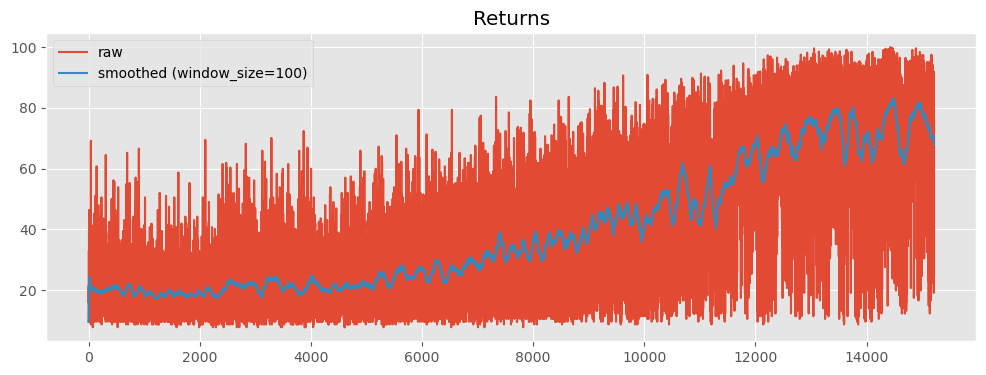

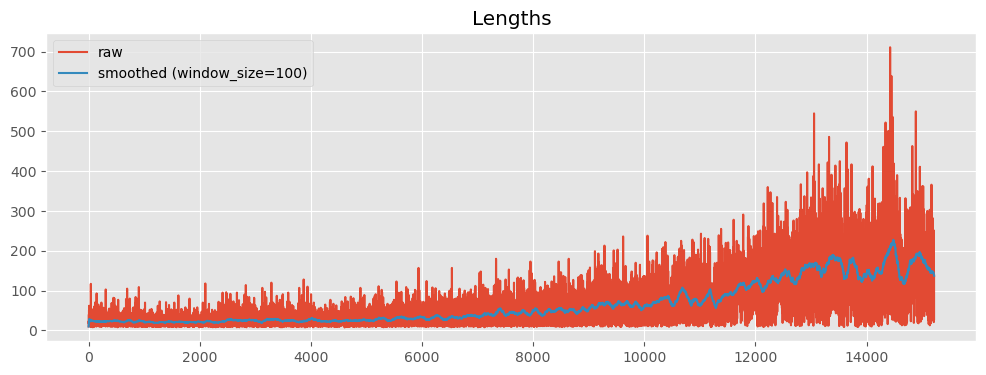

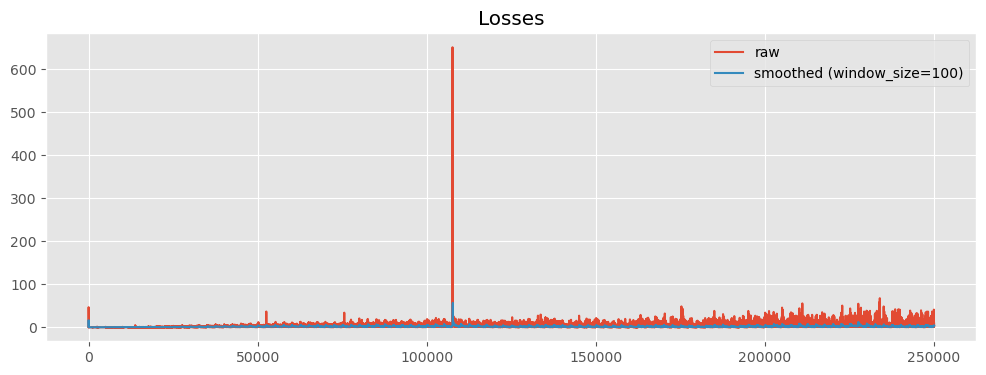

In [17]:
plot_raw_smoothed(cartpole_returns, "Returns")
plot_raw_smoothed(cartpole_lengths, "Lengths")

plot_raw_smoothed(cartpole_losses, "Losses")

In [21]:
import imageio


def eval_cnn_dqn(env, dqn):
    all_frames = []

    img_buffer = ImageBuffer()
    state = env.reset()
    
    img_buffer.add(preprocess_frame(env.render()))

    while True:
        if device == torch.device('cuda'):
            action = dqn(
                torch.from_numpy(img_buffer.get().reshape(1, 4, 100, 400)).cuda()
                ).argmax().item()
        else:
            action = dqn(
                torch.from_numpy(img_buffer.get().reshape(1, 4, 100, 400))
                ).argmax().item()
        all_frames.append(env.render())

        state, _, done, _, _ = env.step(action)
                
        img_buffer.add(preprocess_frame(env.render()))
        
        if done:
            break

    env.close()
    
    imageio.mimwrite(os.path.join('./videos/', 'agent_performing.gif'), all_frames, duration=1000/30)
    
    
    
buttons_all = []


for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f"checkpoint_{env.spec.id}.pt")
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value).to(device)

            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    eval_cnn_dqn(
                        env,
                        dqn,
                    )

                    for b in buttons_all:
                        b.disabled = False

                return button_callback

            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)

        print(f"{key_env}:")
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

cartpole:
